In [191]:
#Importing packages
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras import backend as K
import itertools
#from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.layers.core import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D,  GlobalMaxPooling2D,AveragePooling2D, Flatten, Dropout, Input, BatchNormalization
from sklearn.metrics import (accuracy_score, f1_score, 
                             precision_score, recall_score, classification_report, confusion_matrix)

In [192]:
#!pip install keras

In [193]:
import torch

# Data pre-processing

In [194]:
path = '/Users/kipkemoivincent/Desktop/Covid/Data'

In [195]:
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 2481

horizontal_flip=True, 
                                                               vertical_flip=True,zoom_range=0.3,

In [196]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,validation_split=0.0001)
train_generator = train_datagen.flow_from_directory(path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset='training')

Found 2481 images belonging to 2 classes.


In [197]:
validation_generator = train_datagen.flow_from_directory(path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=743,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset='validation')

Found 0 images belonging to 2 classes.


In [198]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : COVID
1 : non-COVID


In [199]:
#!pip install numpy==1.20

In [200]:
def report(arr1,arr2):
    print ('\x1b[6;30;46m'+'Accuracy:'+str(np.round(accuracy_score(arr1, arr2),4))+','+' Precision:'+str(np.round(precision_score(arr1, arr2),4))+','+
    ' Recall:'+str(np.round(recall_score(arr1, arr2),4))+','+' F1_score:'+str(np.round(f1_score(arr1, arr2),4)))
    return              

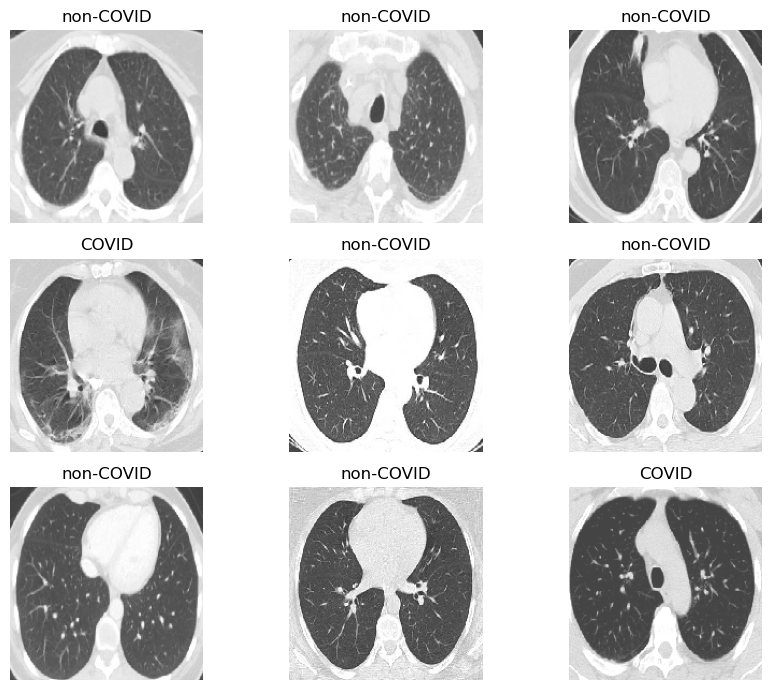

In [216]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 7)) 
idx = 0

for i in range(3): 
    for j in range(3): 
        label = labels[np.argmax(train_generator[0][1][idx])] 
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :]) 
        ax[i, j].axis("off") 
        idx += 1

plt.tight_layout() 
#plt.suptitle("Sample Training Images", fontsize=21) 
plt.show()

In [201]:
X, y = next(train_generator)
X=(X-X.mean())/X.std()
#X_test, y_test = next(validation_generator)

In [202]:
from sklearn.model_selection import train_test_split
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

In [203]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.20, random_state=42, shuffle=True)

In [204]:
X_train.shape,X_val.shape, X_test.shape

((1785, 100, 100, 3), (447, 100, 100, 3), (249, 100, 100, 3))

In [205]:
IMPUT_SHAPE=(IMG_WIDTH, IMG_HEIGHT, 3)

# Prediction using different Architectures

# A. CustomCNN

In [206]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
initializer = tf.keras.initializers.HeNormal()
values = initializer(shape=(2, 2))

In [207]:
from sklearn.utils import compute_class_weight
y=[np.argmax(i) for i in y_train]
class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y),y = y)
class_weights = dict(zip(np.unique(y), class_weights))

In [208]:
input_data = Input(shape=IMPUT_SHAPE)

#Convolution
x = Conv2D(32, (3, 3), activation="relu")(input_data)

#Pooling
x = MaxPooling2D(pool_size = (4, 4), strides=(4, 4))(x)

#Dropout
x = Dropout(0.25)(x)

# 2nd Convolution
x = Conv2D(32, (3, 3), activation="relu")(x)

# 2nd Pooling layer
x = MaxPooling2D(pool_size = (2, 2))(x)

#Dropout
x = Dropout(0.3)(x)

#3rd Convolution
x = Conv2D(32, (3, 3), activation='relu')(x)

#3rd Pooling Layer
x = MaxPooling2D(pool_size=(2, 2))(x)

#Dropout
x = Dropout(0.3)(x)

# Flatten the layer
x = Flatten()(x)

# Fully Connected Layers
x =Dense(128, activation = 'relu')(x)
output = Dense(2, activation = 'softmax')(x)

cnn =keras.models.Model(inputs=input_data, outputs=output)

# Compile the Neural network
cnn.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [209]:
cnn.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 11, 11, 32)        0   

In [210]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
filepath11="weights.best_custom_cnn1.hdf5"
checkpoint1 = ModelCheckpoint(filepath11, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list = [checkpoint1,es,rlrop]

In [214]:
history1 = cnn.fit(X_train,y_train,epochs = 100,verbose = 1,batch_size=4,
                  validation_data =(X_test,y_test),callbacks=callbacks_list,
                 class_weight=class_weights)

Epoch 1/100
447/447 [==============================] - 21s 47ms/step - loss: 0.4127 - accuracy: 0.8174 - val_loss: 0.4005 - val_accuracy: 0.8635

Epoch 00001: val_accuracy improved from 0.85141 to 0.86345, saving model to weights.best_custom_cnn1.hdf5
Epoch 2/100
447/447 [==============================] - 18s 39ms/step - loss: 0.4194 - accuracy: 0.8235 - val_loss: 0.3922 - val_accuracy: 0.8675

Epoch 00002: val_accuracy improved from 0.86345 to 0.86747, saving model to weights.best_custom_cnn1.hdf5
Epoch 3/100
447/447 [==============================] - 17s 39ms/step - loss: 0.3959 - accuracy: 0.8398 - val_loss: 0.3935 - val_accuracy: 0.8675

Epoch 00003: val_accuracy did not improve from 0.86747
Epoch 4/100
447/447 [==============================] - 17s 39ms/step - loss: 0.3778 - accuracy: 0.8314 - val_loss: 0.3799 - val_accuracy: 0.8675

Epoch 00004: val_accuracy did not improve from 0.86747
Epoch 5/100
447/447 [==============================] - 20s 44ms/step - loss: 0.3849 - accuracy

447/447 [==============================] - 16s 36ms/step - loss: 0.2033 - accuracy: 0.9221 - val_loss: 0.2184 - val_accuracy: 0.9157

Epoch 00039: val_accuracy did not improve from 0.91566
Epoch 40/100
447/447 [==============================] - 17s 39ms/step - loss: 0.2215 - accuracy: 0.9148 - val_loss: 0.2193 - val_accuracy: 0.9157

Epoch 00040: val_accuracy did not improve from 0.91566
Epoch 41/100
447/447 [==============================] - 18s 40ms/step - loss: 0.2124 - accuracy: 0.9165 - val_loss: 0.2344 - val_accuracy: 0.9116

Epoch 00041: val_accuracy did not improve from 0.91566
Epoch 42/100
447/447 [==============================] - 17s 39ms/step - loss: 0.2150 - accuracy: 0.9059 - val_loss: 0.2268 - val_accuracy: 0.9076

Epoch 00042: val_accuracy did not improve from 0.91566
Epoch 43/100
447/447 [==============================] - 18s 40ms/step - loss: 0.2063 - accuracy: 0.9160 - val_loss: 0.2251 - val_accuracy: 0.9116

Epoch 00043: val_accuracy did not improve from 0.91566
Epo

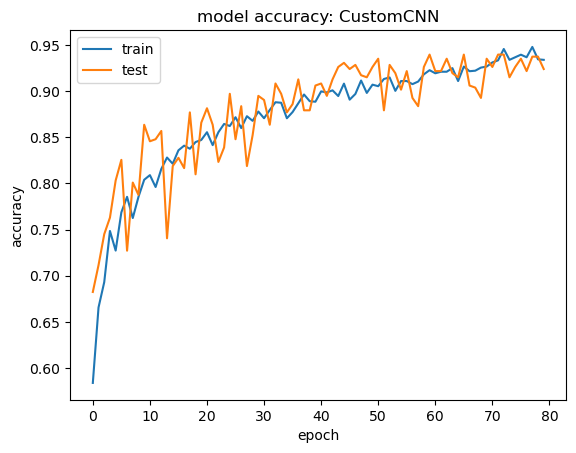

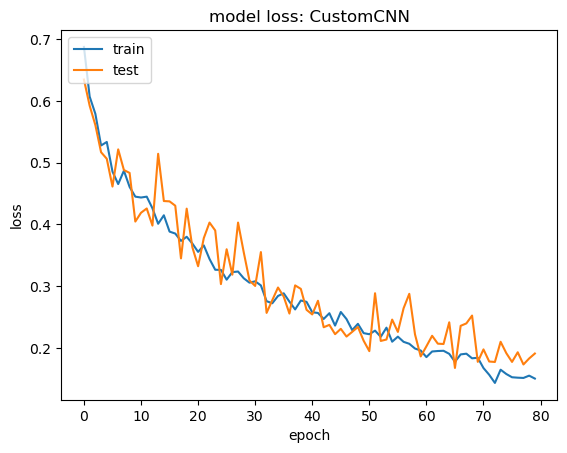

In [23]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy: CustomCNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss: CustomCNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
# load the saved model
from keras.models import load_model
cnn=load_model('weights.best_custom_cnn.hdf5')

In [108]:
pred1=cnn.predict(X_test)
Pred=[np.argmax(i) for i in pred1]
Y_test=[np.argmax(i) for i in y_test]
report(Y_test,Pred)

Accuracy:0.9398, Precision:0.9672, Recall:0.9147, F1_score:0.9402


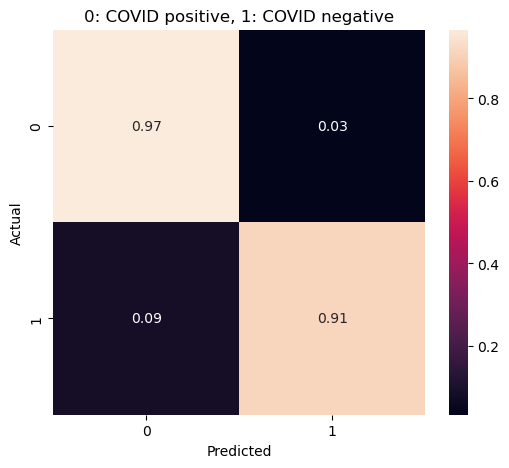

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: COVID positive, 1: COVID negative')
plt.show(block=False)

In [110]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "customCNN.h5")
# load and evaluate a saved model
loaded_model = models.load_model('customCNN.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

# B. MobileNetV2 

In [28]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def make_mobilenet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
# Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(2, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [29]:
filepath21="weights.best_mobile_net.hdf5"
checkpoint2 = ModelCheckpoint(filepath21, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es2 = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop2 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list2 = [checkpoint2,es2,rlrop2]

In [30]:
# Define a model using the make_model function
image_size = (100,100,3)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 2)

# Preview the Model Summary
mobilenet_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258 

In [31]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']

mobilenet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [32]:
history2= mobilenet_model.fit(X_train, y_train,batch_size = 4, epochs = 100, validation_data = (X_val, y_val), 
                                                callbacks=callbacks_list2, class_weight=class_weights)

Epoch 1/100
447/447 [==============================] - 35s 68ms/step - loss: 0.7841 - accuracy: 0.6338 - val_loss: 0.4115 - val_accuracy: 0.8054

Epoch 00001: val_accuracy improved from -inf to 0.80537, saving model to weights.best_mobile_net.hdf5
Epoch 2/100
447/447 [==============================] - 26s 59ms/step - loss: 0.4576 - accuracy: 0.7968 - val_loss: 0.3612 - val_accuracy: 0.8389

Epoch 00002: val_accuracy improved from 0.80537 to 0.83893, saving model to weights.best_mobile_net.hdf5
Epoch 3/100
447/447 [==============================] - 26s 59ms/step - loss: 0.4014 - accuracy: 0.8213 - val_loss: 0.3493 - val_accuracy: 0.8322

Epoch 00003: val_accuracy did not improve from 0.83893
Epoch 4/100
447/447 [==============================] - 26s 59ms/step - loss: 0.3433 - accuracy: 0.8612 - val_loss: 0.2882 - val_accuracy: 0.8792

Epoch 00004: val_accuracy improved from 0.83893 to 0.87919, saving model to weights.best_mobile_net.hdf5
Epoch 5/100
447/447 [============================


Epoch 00039: val_accuracy did not improve from 0.93736
Epoch 40/100
447/447 [==============================] - 24s 55ms/step - loss: 0.0621 - accuracy: 0.9757 - val_loss: 0.1667 - val_accuracy: 0.9418

Epoch 00040: val_accuracy improved from 0.93736 to 0.94183, saving model to weights.best_mobile_net.hdf5
Epoch 41/100
447/447 [==============================] - 24s 55ms/step - loss: 0.0469 - accuracy: 0.9856 - val_loss: 0.1648 - val_accuracy: 0.9418

Epoch 00041: val_accuracy did not improve from 0.94183
Epoch 42/100
447/447 [==============================] - 26s 58ms/step - loss: 0.0515 - accuracy: 0.9880 - val_loss: 0.1672 - val_accuracy: 0.9396

Epoch 00042: val_accuracy did not improve from 0.94183
Epoch 43/100
447/447 [==============================] - 26s 58ms/step - loss: 0.0520 - accuracy: 0.9848 - val_loss: 0.1691 - val_accuracy: 0.9306

Epoch 00043: val_accuracy did not improve from 0.94183
Epoch 44/100
447/447 [==============================] - 28s 62ms/step - loss: 0.0525 -

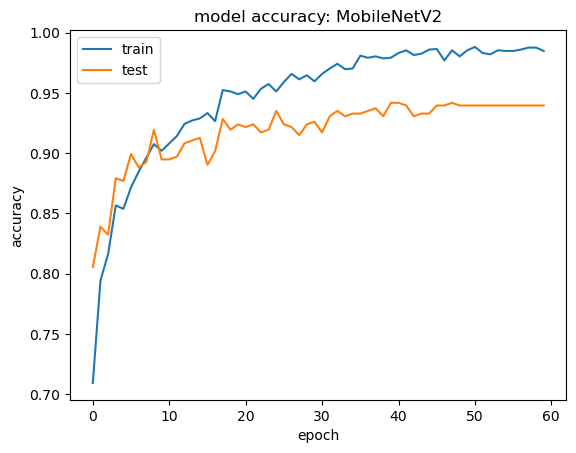

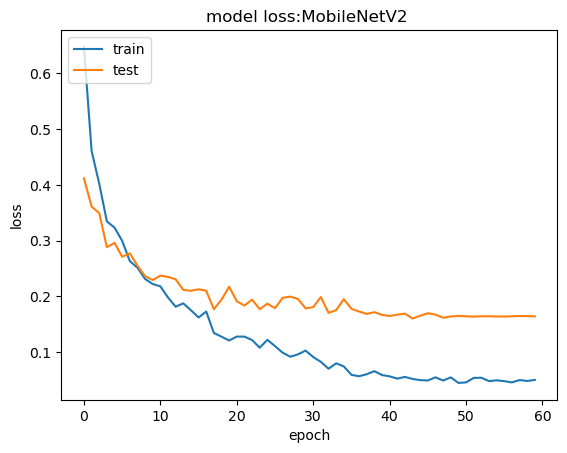

In [34]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy: MobileNetV2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss:MobileNetV2 ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [111]:
mobilenet_model=load_model('weights.best_mobile_net.hdf5')

In [112]:
pred2=mobilenet_model.predict(X_test)
Pred=[np.argmax(i) for i in pred2]
Y_test=[np.argmax(i) for i in y_test]
report(Y_test,Pred)

Accuracy:0.9679, Precision:0.984, Recall:0.9535, F1_score:0.9685


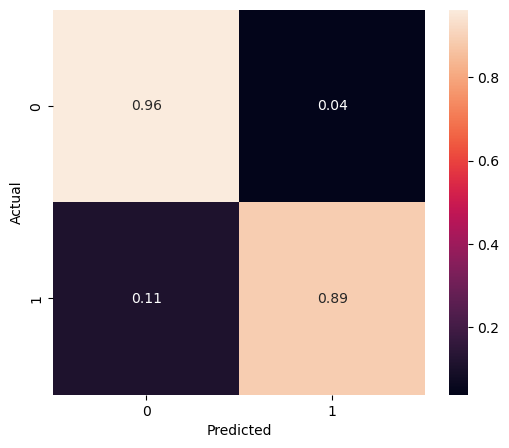

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: COVID positive, 1: COVID negative')
plt.show(block=False)

In [38]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "Mobilenetv2.h5")
# load and evaluate a saved model
loaded_model = models.load_model('Mobilenetv2.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

# C: DenseNet169

In [60]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [61]:
from tensorflow.keras.applications import DenseNet169

In [62]:
def make_densenet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.DenseNet169(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    # Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(2, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [63]:
image_size = (100,100,3)
densenet_model = make_densenet_model(image_size, num_classes = 2)

# Preview the Model Summary
densenet_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 3, 3, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1664)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               213120    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258 

In [64]:
filepath31="weights.best_densenet169.hdf5"
checkpoint3 = ModelCheckpoint(filepath31, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es3 = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop3 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list3 = [checkpoint3,es3,rlrop3]

In [65]:
densenet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [66]:
history3 = densenet_model.fit(X_train, y_train,epochs = 100,verbose = 1,batch_size=2,validation_data =(X_val,y_val)
                    ,callbacks=callbacks_list3,class_weight=class_weights)

Epoch 1/100
893/893 [==============================] - 114s 115ms/step - loss: 0.9678 - accuracy: 0.5981 - val_loss: 0.4422 - val_accuracy: 0.7718

Epoch 00001: val_accuracy improved from -inf to 0.77181, saving model to weights.best_densenet169.hdf5
Epoch 2/100
893/893 [==============================] - 106s 119ms/step - loss: 0.4773 - accuracy: 0.7693 - val_loss: 0.3513 - val_accuracy: 0.8680

Epoch 00002: val_accuracy improved from 0.77181 to 0.86801, saving model to weights.best_densenet169.hdf5
Epoch 3/100
893/893 [==============================] - 101s 113ms/step - loss: 0.3922 - accuracy: 0.8243 - val_loss: 0.3855 - val_accuracy: 0.8367

Epoch 00003: val_accuracy did not improve from 0.86801
Epoch 4/100
893/893 [==============================] - 100s 112ms/step - loss: 0.3757 - accuracy: 0.8545 - val_loss: 0.4218 - val_accuracy: 0.8322

Epoch 00004: val_accuracy did not improve from 0.86801
Epoch 5/100
893/893 [==============================] - 99s 111ms/step - loss: 0.3248 - ac


Epoch 00038: val_accuracy did not improve from 0.94407
Epoch 39/100
893/893 [==============================] - 108s 121ms/step - loss: 0.0802 - accuracy: 0.9734 - val_loss: 0.1816 - val_accuracy: 0.9374

Epoch 00039: val_accuracy did not improve from 0.94407
Epoch 40/100
893/893 [==============================] - 111s 125ms/step - loss: 0.0977 - accuracy: 0.9675 - val_loss: 0.1751 - val_accuracy: 0.9329

Epoch 00040: val_accuracy did not improve from 0.94407
Epoch 41/100
893/893 [==============================] - 110s 123ms/step - loss: 0.0908 - accuracy: 0.9701 - val_loss: 0.1720 - val_accuracy: 0.9351

Epoch 00041: val_accuracy did not improve from 0.94407
Epoch 42/100
893/893 [==============================] - 112s 126ms/step - loss: 0.0742 - accuracy: 0.9752 - val_loss: 0.1744 - val_accuracy: 0.9396

Epoch 00042: val_accuracy did not improve from 0.94407
Epoch 43/100
893/893 [==============================] - 114s 127ms/step - loss: 0.0724 - accuracy: 0.9769 - val_loss: 0.1795 - v

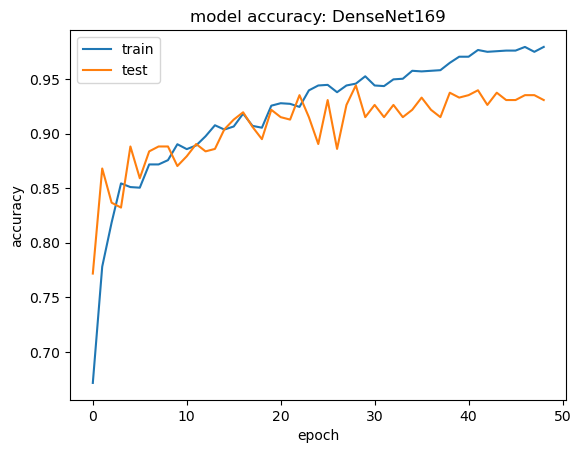

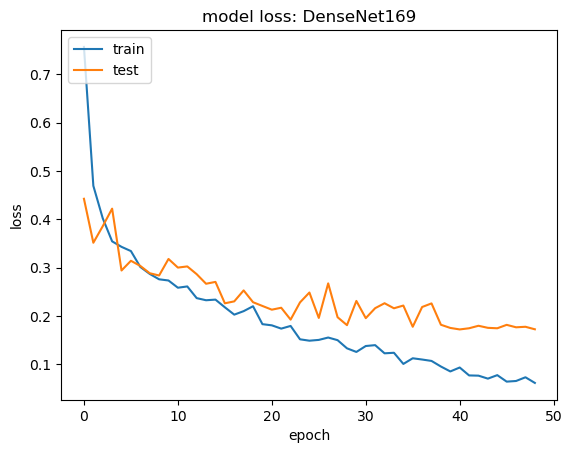

In [68]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy: DenseNet169')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss: DenseNet169')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [113]:
model=load_model('weights.best_densenet169.hdf5')

In [160]:
pred3=model.predict(X_test)
Pred=[np.argmax(i) for i in pred3]
Y_test=[np.argmax(i) for i in y_test]
report(Y_test,Pred)

Accuracy:0.9759, Precision:0.9767, Recall:0.9767, F1_score:0.9767


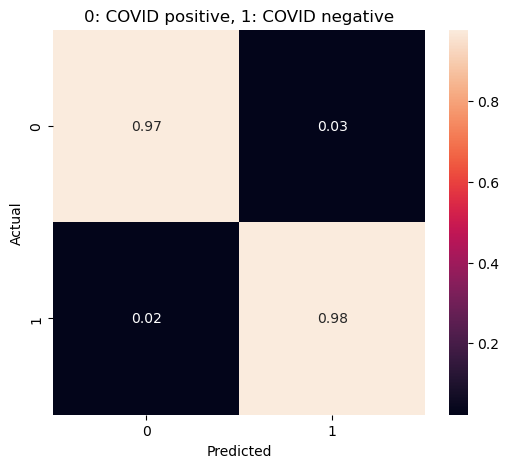

In [161]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: COVID positive, 1: COVID negative')
plt.show(block=False)

In [81]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "DenseNet169.h5")
# load and evaluate a saved model
loaded_model = models.load_model('DenseNet169.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

# D: ResNet50

In [82]:
def make_resnet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    # Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(2, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [83]:
image_size = (100,100,3)
resnet_model = make_resnet_model(image_size, num_classes = 2)

# Preview the Model Summary
resnet_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258 

In [84]:
filepath51="weights.best_ResNet50.hdf5"
checkpoint4 = ModelCheckpoint(filepath51, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es4 = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop4 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list4 = [checkpoint4,es4,rlrop4]

In [87]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']

resnet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [88]:
history4 = resnet_model.fit(X_train, y_train,epochs = 100,verbose = 1,batch_size=2,validation_data =(X_val,y_val)
                    ,callbacks=callbacks_list4,class_weight=class_weights)

Epoch 1/100
893/893 [==============================] - 138s 149ms/step - loss: 0.6426 - accuracy: 0.6485 - val_loss: 0.5035 - val_accuracy: 0.7584

Epoch 00001: val_accuracy improved from -inf to 0.75839, saving model to weights.best_ResNet50.hdf5
Epoch 2/100
893/893 [==============================] - 126s 141ms/step - loss: 0.4922 - accuracy: 0.7527 - val_loss: 0.4625 - val_accuracy: 0.7785

Epoch 00002: val_accuracy improved from 0.75839 to 0.77852, saving model to weights.best_ResNet50.hdf5
Epoch 3/100
893/893 [==============================] - 120s 134ms/step - loss: 0.4864 - accuracy: 0.7491 - val_loss: 0.4464 - val_accuracy: 0.7830

Epoch 00003: val_accuracy improved from 0.77852 to 0.78300, saving model to weights.best_ResNet50.hdf5
Epoch 4/100
893/893 [==============================] - 119s 134ms/step - loss: 0.4507 - accuracy: 0.7651 - val_loss: 0.4773 - val_accuracy: 0.7562

Epoch 00004: val_accuracy did not improve from 0.78300
Epoch 5/100
893/893 [==========================


Epoch 00076: val_accuracy did not improve from 0.92170
Epoch 77/100
893/893 [==============================] - 122s 137ms/step - loss: 0.1048 - accuracy: 0.9671 - val_loss: 0.2132 - val_accuracy: 0.9172

Epoch 00077: val_accuracy did not improve from 0.92170
Epoch 78/100
893/893 [==============================] - 122s 137ms/step - loss: 0.1205 - accuracy: 0.9515 - val_loss: 0.2098 - val_accuracy: 0.9172

Epoch 00078: val_accuracy did not improve from 0.92170
Epoch 79/100
893/893 [==============================] - 123s 137ms/step - loss: 0.1206 - accuracy: 0.9553 - val_loss: 0.2085 - val_accuracy: 0.9172

Epoch 00079: val_accuracy did not improve from 0.92170
Epoch 80/100
893/893 [==============================] - 123s 138ms/step - loss: 0.1182 - accuracy: 0.9573 - val_loss: 0.2076 - val_accuracy: 0.9239

Epoch 00080: val_accuracy improved from 0.92170 to 0.92394, saving model to weights.best_ResNet50.hdf5
Epoch 81/100
893/893 [==============================] - 127s 143ms/step - loss: 

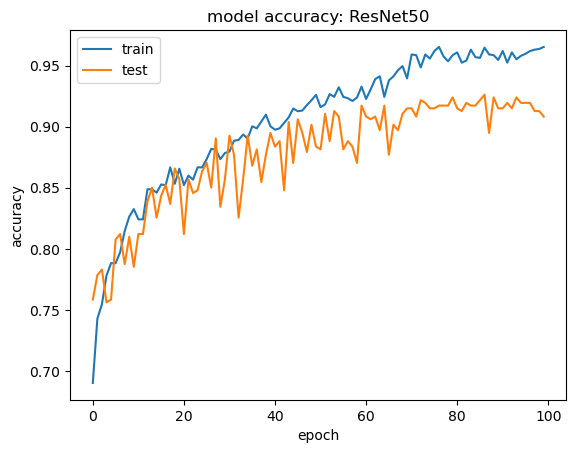

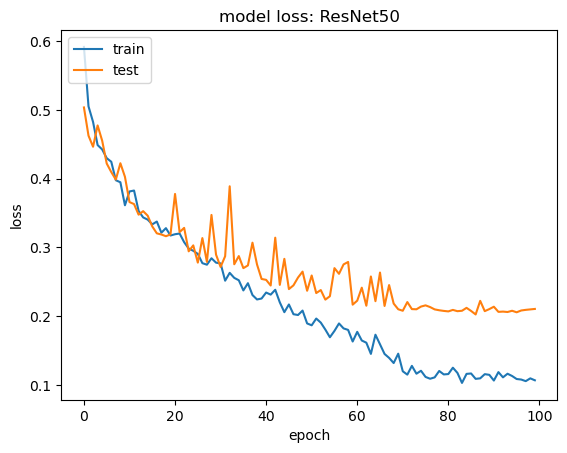

In [89]:
# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy: ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss: ResNet50')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [115]:
model=load_model('weights.best_ResNet50.hdf5')

In [116]:
pred4=model.predict(X_test)
Pred=[np.argmax(i) for i in pred4]
Y_test=[np.argmax(i) for i in y_test]
report(Y_test,Pred)

Accuracy:0.9759, Precision:0.9767, Recall:0.9767, F1_score:0.9767


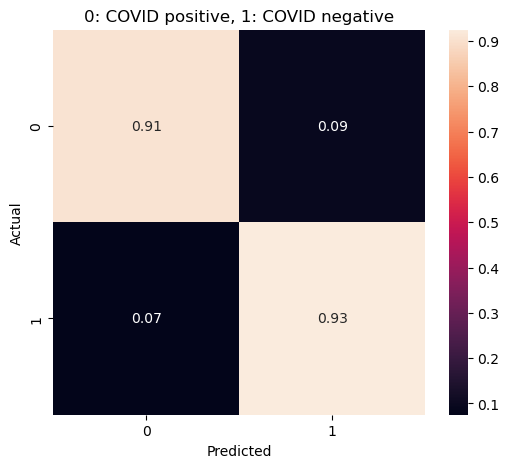

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: COVID positive, 1: COVID negative')
plt.show(block=False)

In [94]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "ResNet50.h5")
# load and evaluate a saved model
loaded_model = models.load_model('ResNet50.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

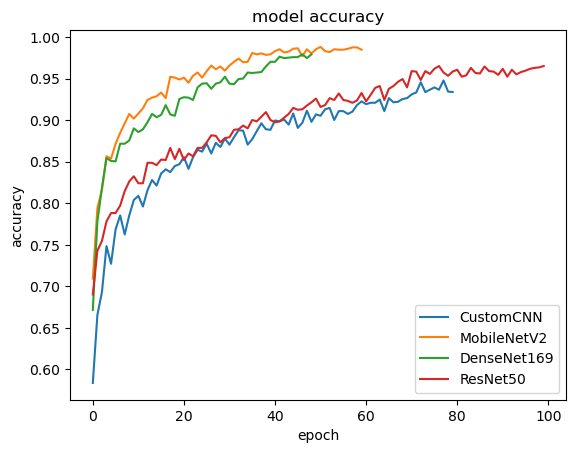

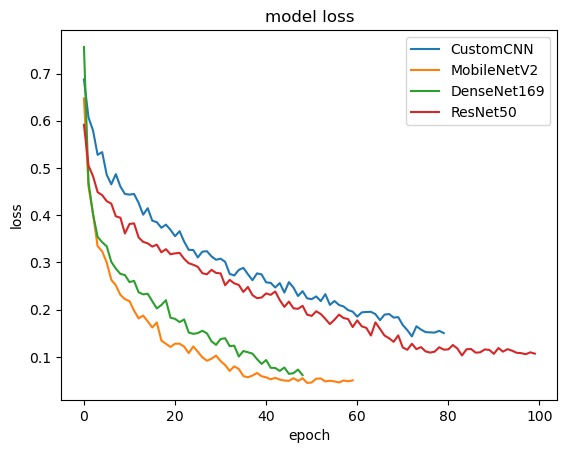

In [180]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CustomCNN', 'MobileNetV2','DenseNet169','ResNet50'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['CustomCNN', 'MobileNetV2','DenseNet169','ResNet50'], loc='upper right')
plt.show()

# ENSEMBLE

To create an ensemble of the four models, we will stack their predictions and use Microsoft FLAML AutoML to find an optimal combiner.

In [129]:
X_data=np.concatenate([pred1,pred2,pred3,pred4], axis=1)
y_data= np.argmax(y_test, axis=1)
X_data.shape, y_data.shape

((249, 8), (249,))

In [132]:
from flaml import AutoML
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 100,  # total running time in seconds
    "task": 'classification',  # task type
    "seed": 24545678,  # random seed
    "metric" : 'accuracy'}

automl.fit(X_train=X_data, y_train=y_data, **automl_settings)

[flaml.automl.logger: 12-19 10:50:50] {1679} INFO - task = classification
[flaml.automl.logger: 12-19 10:50:50] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 12-19 10:50:50] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 12-19 10:50:50] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 12-19 10:50:50] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-19 10:50:50] {2344} INFO - Estimated sufficient time budget=1163s. Estimated necessary time budget=27s.
[flaml.automl.logger: 12-19 10:50:50] {2391} INFO -  at 0.1s,	estimator lgbm's best error=0.0201,	best estimator lgbm's best error=0.0201
[flaml.automl.logger: 12-19 10:50:50] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-19 10:50:50] {2391} INFO -  at 0.3s,	estimator lgbm's best error=0.0201,	best estimator lgbm's best error=0.0201
[flaml.automl.logger: 12-19 10:50:

[flaml.automl.logger: 12-19 10:50:55] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 12-19 10:50:55] {2391} INFO -  at 5.7s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:50:55] {2218} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 12-19 10:50:56] {2391} INFO -  at 5.7s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:50:56] {2218} INFO - iteration 36, current learner rf
[flaml.automl.logger: 12-19 10:50:56] {2391} INFO -  at 6.1s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:50:56] {2218} INFO - iteration 37, current learner rf
[flaml.automl.logger: 12-19 10:50:56] {2391} INFO -  at 6.3s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:50:56] {2218} INFO - iteration 38, current learner rf
[flaml.automl.logger: 1

[flaml.automl.logger: 12-19 10:51:01] {2218} INFO - iteration 71, current learner lgbm
[flaml.automl.logger: 12-19 10:51:02] {2391} INFO -  at 11.7s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:02] {2218} INFO - iteration 72, current learner rf
[flaml.automl.logger: 12-19 10:51:02] {2391} INFO -  at 12.0s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:02] {2218} INFO - iteration 73, current learner lgbm
[flaml.automl.logger: 12-19 10:51:02] {2391} INFO -  at 12.0s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:02] {2218} INFO - iteration 74, current learner rf
[flaml.automl.logger: 12-19 10:51:02] {2391} INFO -  at 12.4s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:02] {2218} INFO - iteration 75, current learner lgbm
[flaml.automl.log

[flaml.automl.logger: 12-19 10:51:09] {2218} INFO - iteration 108, current learner rf
[flaml.automl.logger: 12-19 10:51:09] {2391} INFO -  at 19.6s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:09] {2218} INFO - iteration 109, current learner rf
[flaml.automl.logger: 12-19 10:51:10] {2391} INFO -  at 20.0s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:10] {2218} INFO - iteration 110, current learner lgbm
[flaml.automl.logger: 12-19 10:51:10] {2391} INFO -  at 20.2s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:10] {2218} INFO - iteration 111, current learner rf
[flaml.automl.logger: 12-19 10:51:10] {2391} INFO -  at 20.7s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:11] {2218} INFO - iteration 112, current learner rf
[flaml.automl.logg

[flaml.automl.logger: 12-19 10:51:18] {2218} INFO - iteration 144, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:19] {2391} INFO -  at 28.9s,	estimator xgb_limitdepth's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:19] {2218} INFO - iteration 145, current learner rf
[flaml.automl.logger: 12-19 10:51:19] {2391} INFO -  at 29.4s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:19] {2218} INFO - iteration 146, current learner lgbm
[flaml.automl.logger: 12-19 10:51:19] {2391} INFO -  at 29.5s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:19] {2218} INFO - iteration 147, current learner lgbm
[flaml.automl.logger: 12-19 10:51:19] {2391} INFO -  at 29.6s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:19] {2218} INFO - iteration 148, current l

[flaml.automl.logger: 12-19 10:51:26] {2218} INFO - iteration 179, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:26] {2391} INFO -  at 36.6s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:26] {2218} INFO - iteration 180, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:27] {2391} INFO -  at 36.9s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:27] {2218} INFO - iteration 181, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:27] {2391} INFO -  at 37.3s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:27] {2218} INFO - iteration 182, current learner rf
[flaml.automl.logger: 12-19 10:51:28] {2391} INFO -  at 37.8s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:28

[flaml.automl.logger: 12-19 10:51:35] {2391} INFO -  at 45.2s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:35] {2218} INFO - iteration 214, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:35] {2391} INFO -  at 45.5s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:35] {2218} INFO - iteration 215, current learner rf
[flaml.automl.logger: 12-19 10:51:36] {2391} INFO -  at 45.9s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:36] {2218} INFO - iteration 216, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:36] {2391} INFO -  at 46.1s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:36] {2218} INFO - iteration 217, current learner lgbm
[flaml.automl.logger: 12-19 10:51:36] {2391} I

[flaml.automl.logger: 12-19 10:51:43] {2391} INFO -  at 53.1s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:43] {2218} INFO - iteration 249, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:43] {2391} INFO -  at 53.3s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:43] {2218} INFO - iteration 250, current learner extra_tree
[flaml.automl.logger: 12-19 10:51:43] {2391} INFO -  at 53.5s,	estimator extra_tree's best error=0.0120,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:43] {2218} INFO - iteration 251, current learner lgbm
[flaml.automl.logger: 12-19 10:51:43] {2391} INFO -  at 53.6s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:43] {2218} INFO - iteration 252, current learner rf
[flaml.automl.logger: 12-19 10:51:44] {2391} INFO -  at 54.0s,

[flaml.automl.logger: 12-19 10:51:50] {2391} INFO -  at 59.7s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:50] {2218} INFO - iteration 284, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:50] {2391} INFO -  at 60.0s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:50] {2218} INFO - iteration 285, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:50] {2391} INFO -  at 60.2s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:50] {2218} INFO - iteration 286, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:51:50] {2391} INFO -  at 60.4s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:50] {2218} INFO - iteration 287, current learner xgboost
[flaml.automl.logger: 12-19 10:

[flaml.automl.logger: 12-19 10:51:57] {2391} INFO -  at 67.0s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:57] {2218} INFO - iteration 319, current learner rf
[flaml.automl.logger: 12-19 10:51:57] {2391} INFO -  at 67.3s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:57] {2218} INFO - iteration 320, current learner xgboost
[flaml.automl.logger: 12-19 10:51:57] {2391} INFO -  at 67.4s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:57] {2218} INFO - iteration 321, current learner xgboost
[flaml.automl.logger: 12-19 10:51:57] {2391} INFO -  at 67.6s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:51:57] {2218} INFO - iteration 322, current learner rf
[flaml.automl.logger: 12-19 10:51:58] {2391} INFO -  at 68.1s,	estimator rf's best err

[flaml.automl.logger: 12-19 10:52:04] {2218} INFO - iteration 354, current learner lgbm
[flaml.automl.logger: 12-19 10:52:04] {2391} INFO -  at 74.1s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:04] {2218} INFO - iteration 355, current learner xgboost
[flaml.automl.logger: 12-19 10:52:04] {2391} INFO -  at 74.2s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:04] {2218} INFO - iteration 356, current learner xgboost
[flaml.automl.logger: 12-19 10:52:04] {2391} INFO -  at 74.3s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:04] {2218} INFO - iteration 357, current learner rf
[flaml.automl.logger: 12-19 10:52:05] {2391} INFO -  at 74.7s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:05] {2218} INFO - iteration 358, current learner r

[flaml.automl.logger: 12-19 10:52:09] {2391} INFO -  at 78.7s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:09] {2218} INFO - iteration 390, current learner rf
[flaml.automl.logger: 12-19 10:52:09] {2391} INFO -  at 78.9s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:09] {2218} INFO - iteration 391, current learner xgboost
[flaml.automl.logger: 12-19 10:52:09] {2391} INFO -  at 79.0s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:09] {2218} INFO - iteration 392, current learner xgboost
[flaml.automl.logger: 12-19 10:52:09] {2391} INFO -  at 79.1s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:09] {2218} INFO - iteration 393, current learner lgbm
[flaml.automl.logger: 12-19 10:52:09] {2391} INFO -  at 79.2s,	estimator lgbm's best e

[flaml.automl.logger: 12-19 10:52:14] {2391} INFO -  at 84.1s,	estimator extra_tree's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:14] {2218} INFO - iteration 425, current learner rf
[flaml.automl.logger: 12-19 10:52:14] {2391} INFO -  at 84.3s,	estimator rf's best error=0.0160,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:14] {2218} INFO - iteration 426, current learner lgbm
[flaml.automl.logger: 12-19 10:52:14] {2391} INFO -  at 84.3s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:14] {2218} INFO - iteration 427, current learner lgbm
[flaml.automl.logger: 12-19 10:52:14] {2391} INFO -  at 84.4s,	estimator lgbm's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:14] {2218} INFO - iteration 428, current learner lgbm
[flaml.automl.logger: 12-19 10:52:14] {2391} INFO -  at 84.4s,	estimator lgbm's best error

[flaml.automl.logger: 12-19 10:52:21] {2391} INFO -  at 91.2s,	estimator extra_tree's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:21] {2218} INFO - iteration 460, current learner extra_tree
[flaml.automl.logger: 12-19 10:52:21] {2391} INFO -  at 91.4s,	estimator extra_tree's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:21] {2218} INFO - iteration 461, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:52:21] {2391} INFO -  at 91.6s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:21] {2218} INFO - iteration 462, current learner xgboost
[flaml.automl.logger: 12-19 10:52:22] {2391} INFO -  at 91.7s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:22] {2218} INFO - iteration 463, current learner xgboost
[flaml.automl.logger: 12-19 10:52:22] {2391} 

[flaml.automl.logger: 12-19 10:52:27] {2391} INFO -  at 97.0s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:27] {2218} INFO - iteration 495, current learner xgboost
[flaml.automl.logger: 12-19 10:52:27] {2391} INFO -  at 97.1s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:27] {2218} INFO - iteration 496, current learner xgb_limitdepth
[flaml.automl.logger: 12-19 10:52:27] {2391} INFO -  at 97.3s,	estimator xgb_limitdepth's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:27] {2218} INFO - iteration 497, current learner xgboost
[flaml.automl.logger: 12-19 10:52:27] {2391} INFO -  at 97.4s,	estimator xgboost's best error=0.0080,	best estimator lgbm's best error=0.0080
[flaml.automl.logger: 12-19 10:52:27] {2218} INFO - iteration 498, current learner rf
[flaml.automl.logger: 12-19 10:52:28] {2391} INFO -  at 97.

In [138]:
pred5=automl.predict(X_data)
report(y_data,pred5)

Accuracy:0.992, Precision:0.9922, Recall:0.9922, F1_score:0.9922


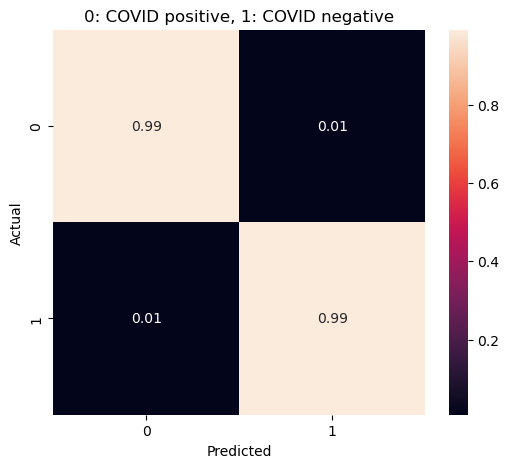

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(y_data, pred5)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: COVID positive, 1: COVID negative')
plt.show(block=False)

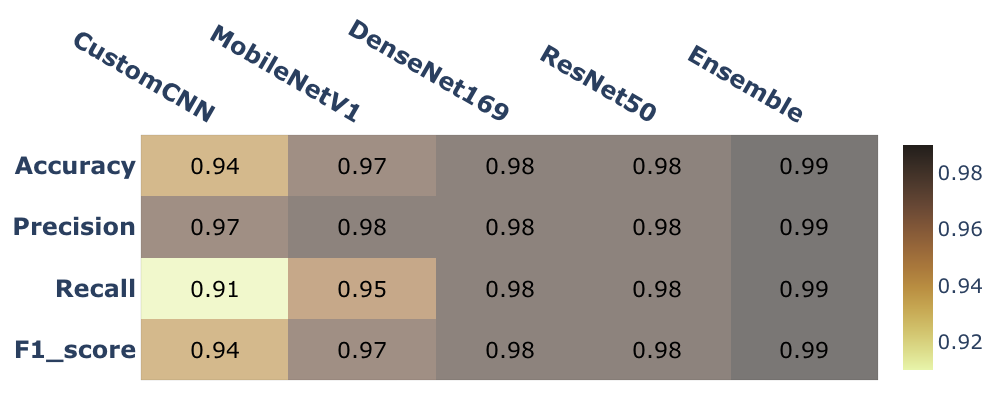

In [179]:
import plotly.graph_objects as go
from functools import reduce
from itertools import product
from IPython.display import Image
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
z=[ [0.94,0.97,0.98,0.98,0.99],[0.91,0.95,0.98,0.98,0.99], [0.97,0.98,0.98,0.98,0.99],[0.94,0.97,0.98,0.98,0.99]]
x=['<b>CustomCNN</b>', '<b>MobileNetV1</b>', '<b>DenseNet169</b>', '<b>ResNet50</b>', '<b>Ensemble</b>']
y=['<b>F1_score</b>', '<b>Recall</b>', '<b>Precision</b>','<b>Accuracy</b>']

def get_anno_text(z_value):
    annotations=[]
    a, b = len(z_value), len(z_value[0])
    flat_z = reduce(lambda x,y: x+y, z_value) # z_value.flat if you deal with numpy
    coords = product(range(a), range(b))
    for pos, elem in zip(coords, flat_z):
        annotations.append({'font': {'color': 'black'},
                    'showarrow': False,
                    'text': str(elem),
                    'x': pos[1],
                    'y': pos[0],
                        'font.size':22   })
    return annotations

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
                   hoverongaps = True, colorscale ='turbid',
    opacity=0.6,colorbar=dict(tickfont=dict(size=20)) ))#matter#

fig.update_layout(title={'text': "",
        'y':0.8,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
           plot_bgcolor='rgba(0,0,0,0)',       
    annotations = get_anno_text(z),
                 width=1000,
height=400,xaxis={'side': 'top'},margin=dict(l=20, r=20, t=20, b=20))

fig.update_xaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
    
                 mirror=True)
fig.update_yaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
        
                 mirror=True)
fig.write_image("table2b.png",engine="kaleido")
#plt.savefig("table2a.pdf", format="pdf", bbox_inches="tight")
fig.show()
Image('table2b.png')